In [1]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [1]:
!pip install torchsummary

Defaulting to user installation because normal site-packages is not writeable


Importing the required packages

In [2]:
import os
import torch
import torch.nn as n
import torch.nn.functional as f
import numpy as np
import os
from torchsummary import summary
import torch.optim as optim
from tqdm import tqdm
from torchvision import models
import cv2
from matplotlib import pyplot as plt
from PIL import Image

In [2]:
import os
import torch
import torch.nn as n
import torch.nn.functional as f
import numpy as np
import os
from torchsummary import summary
import torch.optim as optim
from tqdm import tqdm
from torchvision import models
import cv2
from matplotlib import pyplot as plt
from PIL import Image

Giving path to the celebrity dataset folder and listing all images

In [3]:
celebData = "/kaggle/input/celeba/img_align_celeba/img_align_celeba"
images = os.listdir(celebData)
print(len(images))
imageList = images[:1500]


202599


In [4]:
len(imageList)

1500

Assigning the device as cuda if GPU is available else cpu

In [5]:
cuda = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

The architecture of  the generator as mentioned in paper

In [6]:
class Generator(n.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = n.Conv2d(3,64,9,padding=4,bias=False)
        self.conv2 = n.Conv2d(64,64,3,padding=1,bias=False)
        self.conv3_1 = n.Conv2d(64,256,3,padding=1,bias=False)
        self.conv3_2 = n.Conv2d(64,256,3,padding=1,bias=False)
        self.conv4 = n.Conv2d(64,3,9,padding=4,bias=False)
        self.bn = n.BatchNorm2d(64)
        self.ps = n.PixelShuffle(2)
        self.prelu = n.PReLU()
        
    def forward(self,x):
        block1 = self.prelu(self.conv1(x))
        block2 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block1))))),block1)
        block3 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block2))))),block2)
        block4 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block3))))),block3)
        block5 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block4))))),block4)
        block6 = torch.add(self.bn(self.conv2(self.prelu(self.bn(self.conv2(block5))))),block5)
        block7 = torch.add(self.bn(self.conv2(block6)),block1)
        block8 = self.prelu(self.ps(self.conv3_1(block7)))
        block9 = self.prelu(self.ps(self.conv3_2(block8)))
        block10 = self.conv4(block9)
        return block10

Assigning the Generator to cuda(if available) and printing the summary of the Generator with a dummy input

In [7]:
gen = Generator().to(cuda)
summary(gen,(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]          15,552
             PReLU-2           [-1, 64, 64, 64]               1
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
             PReLU-5           [-1, 64, 64, 64]               1
            Conv2d-6           [-1, 64, 64, 64]          36,864
       BatchNorm2d-7           [-1, 64, 64, 64]             128
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
            PReLU-10           [-1, 64, 64, 64]               1
           Conv2d-11           [-1, 64, 64, 64]          36,864
      BatchNorm2d-12           [-1, 64, 64, 64]             128
           Conv2d-13           [-1, 64, 64, 64]          36,864
      BatchNorm2d-14           [-1, 64,

The Discriminator network as given in the paper except that a dropout in the last layer

In [8]:
class Discriminator(n.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = n.Conv2d(3,64,3,padding=1,bias=False)
        self.conv2 = n.Conv2d(64,64,3,stride=2,padding=1,bias=False)
        self.bn2 = n.BatchNorm2d(64)
        self.conv3 = n.Conv2d(64,128,3,padding=1,bias=False)
        self.bn3 = n.BatchNorm2d(128)
        self.conv4 = n.Conv2d(128,128,3,stride=2,padding=1,bias=False)
        self.bn4 = n.BatchNorm2d(128)
        self.conv5 = n.Conv2d(128,256,3,padding=1,bias=False)
        self.bn5 = n.BatchNorm2d(256)
        self.conv6 = n.Conv2d(256,256,3,stride=2,padding=1,bias=False)
        self.bn6 = n.BatchNorm2d(256)
        self.conv7 = n.Conv2d(256,512,3,padding=1,bias=False)
        self.bn7 = n.BatchNorm2d(512)
        self.conv8 = n.Conv2d(512,512,3,stride=2,padding=1,bias=False)
        self.bn8 = n.BatchNorm2d(512)
        self.fc1 = n.Linear(512*16*16,1024)
        self.fc2 = n.Linear(1024,1)
        self.drop = n.Dropout2d(0.3)
        
    def forward(self,x):
        block1 = f.leaky_relu(self.conv1(x))
        block2 = f.leaky_relu(self.bn2(self.conv2(block1)))
        block3 = f.leaky_relu(self.bn3(self.conv3(block2)))
        block4 = f.leaky_relu(self.bn4(self.conv4(block3)))
        block5 = f.leaky_relu(self.bn5(self.conv5(block4)))
        block6 = f.leaky_relu(self.bn6(self.conv6(block5)))
        block7 = f.leaky_relu(self.bn7(self.conv7(block6)))
        block8 = f.leaky_relu(self.bn8(self.conv8(block7)))
        block8 = block8.view(-1,block8.size(1)*block8.size(2)*block8.size(3))
        block9 = f.leaky_relu(self.fc1(block8),)
#         block9 = block9.view(-1,block9.size(1)*block9.size(2)*block9.size(3))
        block10 = torch.sigmoid(self.drop(self.fc2(block9)))
        return block9,block10

Assigning the discriminator to the gpu(if available) and printing the summary of the network with a dummy value

In [9]:
disc = Discriminator().to(cuda)
summary(disc,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,728
            Conv2d-2         [-1, 64, 128, 128]          36,864
       BatchNorm2d-3         [-1, 64, 128, 128]             128
            Conv2d-4        [-1, 128, 128, 128]          73,728
       BatchNorm2d-5        [-1, 128, 128, 128]             256
            Conv2d-6          [-1, 128, 64, 64]         147,456
       BatchNorm2d-7          [-1, 128, 64, 64]             256
            Conv2d-8          [-1, 256, 64, 64]         294,912
       BatchNorm2d-9          [-1, 256, 64, 64]             512
           Conv2d-10          [-1, 256, 32, 32]         589,824
      BatchNorm2d-11          [-1, 256, 32, 32]             512
           Conv2d-12          [-1, 512, 32, 32]       1,179,648
      BatchNorm2d-13          [-1, 512, 32, 32]           1,024
           Conv2d-14          [-1, 512,

/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [10]:
disc = Discriminator().to(cuda).float()
gen = Generator().to(cuda).float()

Downloading the pretrained vgg19 model from model module of torchvision library

In [11]:
vgg = models.vgg19(pretrained=True).to(cuda)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 94.8MB/s] 


Defining the losses to be used in training

In [12]:
gen_loss = n.BCELoss()
vgg_loss = n.MSELoss()
mse_loss = n.MSELoss()
disc_loss = n.BCELoss()

Defining the adam optimizers for generator and discriminator

In [13]:
gen_optimizer = optim.Adam(gen.parameters(),lr=0.0001)
disc_optimizer = optim.Adam(disc.parameters(),lr=0.0001)

Loading the images after based on resizing as numpy array

In [14]:
def loadImages(imageList,path,resize=False):
    images=[]
    for image in (imageList):
#         print(image)
        if resize:
            img = cv2.resize(cv2.imread(os.path.join(path,image)),(256,256)) 
        else:
            img = cv2.imread(os.path.join(path,image))
        img = np.moveaxis(img, 2, 0)
#         print(img.shape)
        images.append(img)
    return np.array(images)

Converting the high resolution images into low resolution by applying gaussian blur, resizing in to 64*64 and loading it as numpy array

In [15]:
def loadLRImages(imagelist,path):
    images=[]
    for image in (imagelist):
        img = cv2.resize(cv2.GaussianBlur(cv2.imread(os.path.join(path,image)),(5,5),cv2.BORDER_DEFAULT),(64,64)) 
        img = np.moveaxis(img, 2, 0)
        images.append(img)
    return np.array(images)

Loading the generator model from the given checkpoint

In [16]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    
    model.eval()
    
    return model

Given low resolution images and checkpoint, Generating the high resolution images out of it 

In [17]:
def imagePostProcess(imagedir,modelPath):
    imagelist=[]
#     images = os.listdir(imagedir)
    for img in imagedir:
        img = cv2.resize(cv2.GaussianBlur(cv2.imread(os.path.join(hr_path,img)),(5,5),cv2.BORDER_DEFAULT),(64,64)) 
        imagelist.append(img)
    imagearray = np.array(imagelist)/255
    imagearrayPT = np.moveaxis(imagearray,3,1)

    model = load_checkpoint(modelPath)
    im_tensor = torch.from_numpy(imagearrayPT).float()
    out_tensor = model(im_tensor)
    out = out_tensor.numpy()
    out = np.moveaxis(out,1,3)
    # print(out.shape)
    out = np.clip(out,0,1)
    
    return out

Display utility of displaying images using matplotlib

In [18]:
def show_samples(sample_images):
    figure, axes = plt.subplots(1, sample_images.shape[0], figsize = (10,10))
    for index, axis in enumerate(axes):
        axis.axis('off')
        image_array = sample_images[index]
        axis.imshow(image_array)
        image = Image.fromarray((image_array * 255).astype('uint8'))
    plt.savefig(os.path.join(base_path,"out/SR")+"_"+str(epoch)+".png", bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()

In [19]:
epochs=100
batch_size=64

In [20]:
import os 
base_path = os.getcwd()

hr_path =celebData
weight_file = os.path.join(base_path,"SRPT_weights")
out_path = os.path.join(base_path,"out")

if not os.path.exists(weight_file):
    os.makedirs(weight_file)

if not os.path.exists(out_path):
    os.makedirs(out_path)

    
#LR_images_list = os.listdir(lr_path)
HR_images_list = imageList
batch_count = len(HR_images_list)//batch_size
batch_count

23

Starting of training and defining losses

In [21]:
Ppath = weight_file
arr = []
for filename in os.listdir(Ppath):
    print(filename)
    arr.append(int(filename.split(".")[0][2:]))
print(max(arr))
latest_num = str(max(arr) - 1)
latest_path = os.path.join(Ppath,"SR"+latest_num+".pth")
print(latest_path)

checkpoint = torch.load(latest_path)
gen.load_state_dict(checkpoint['state_dict'])

SR20.pth
SR4.pth
SR15.pth
SR3.pth
SR13.pth
SR23.pth
SR7.pth
SR11.pth
SR12.pth
SR5.pth
SR26.pth
SR1.pth
SR10.pth
SR6.pth
SR14.pth
SR16.pth
SR19.pth
SR18.pth
SR21.pth
SR2.pth
SR9.pth
SR24.pth
SR8.pth
SR22.pth
SR25.pth
SR17.pth
26
/kaggle/working/SRPT_weights/SR25.pth


<All keys matched successfully>

100%|██████████| 23/23 [49:29<00:00, 129.11s/it]


Epoch ::::  26  d1_loss ::: 1.1372244999460552  d2_loss :::2.5649069126533424
genLoss ::: 2.581035301089287  vggLoss ::: 0.07139944349942  MeanLoss  ::: 0.005462370944492843


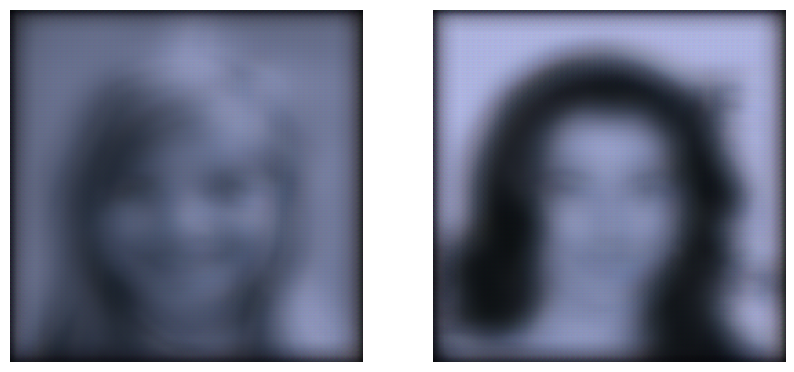

Loaded checkpoint for epoch 25


100%|██████████| 23/23 [49:38<00:00, 129.51s/it]


Epoch ::::  27  d1_loss ::: 0.6744471373765365  d2_loss :::0.6659213200859402
genLoss ::: 0.7568641615950543  vggLoss ::: 0.06825118139386177  MeanLoss  ::: 0.0024514016948397393


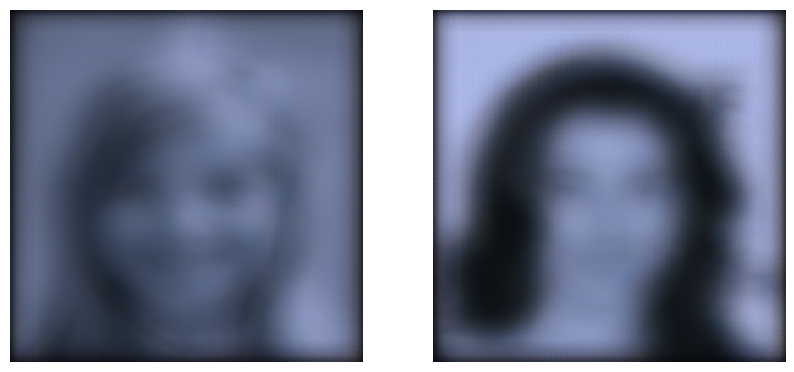

Loaded checkpoint for epoch 26


100%|██████████| 23/23 [50:02<00:00, 130.54s/it]


Epoch ::::  28  d1_loss ::: 0.48743135384891345  d2_loss :::0.4798476773759593
genLoss ::: 1.461190420648326  vggLoss ::: 0.06779384305295737  MeanLoss  ::: 0.0025364116451743503


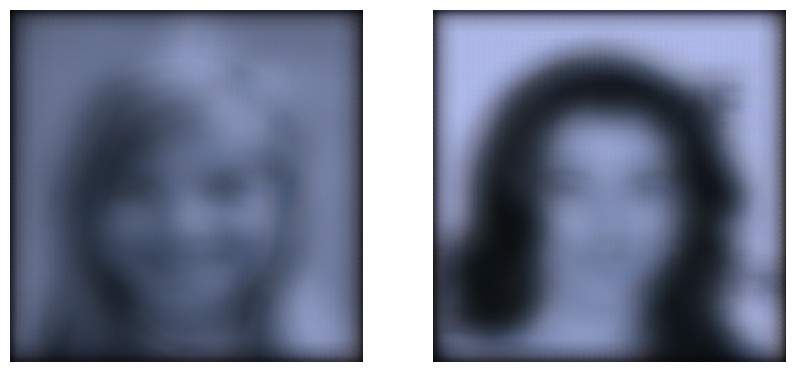

Loaded checkpoint for epoch 27


100%|██████████| 23/23 [50:15<00:00, 131.09s/it]


Epoch ::::  29  d1_loss ::: 0.23548091494518777  d2_loss :::0.24485774273457733
genLoss ::: 5.161951707757038  vggLoss ::: 0.06713565746727197  MeanLoss  ::: 0.002330544622331534


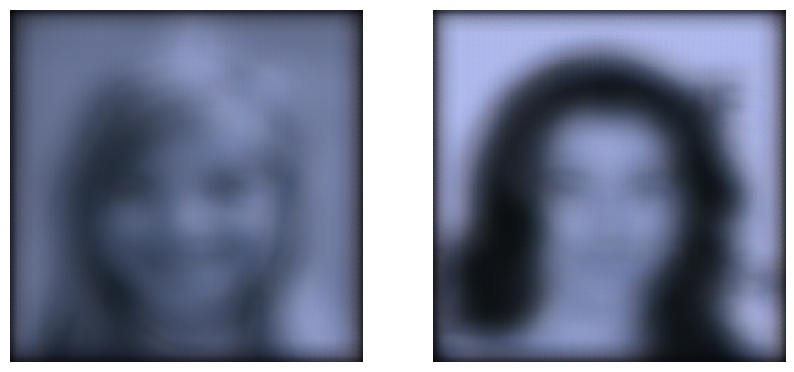

Loaded checkpoint for epoch 28


 26%|██▌       | 6/23 [12:53<36:29, 128.78s/it]

In [ ]:
#batch_count=60
for epoch in range(int(latest_num),epochs):
    d1loss_list=[]
    d2loss_list=[]
    gloss_list=[]
    vloss_list=[]
    mloss_list=[]
    
    for batch in tqdm(range(batch_count)):
        hr_imagesList = [img for img in HR_images_list[batch*batch_size:(batch+1)*batch_size]]
        lr_images = loadLRImages(hr_imagesList,hr_path)/255
        hr_images = loadImages(hr_imagesList,hr_path,True)/255
        
                
        disc.zero_grad()

        gen_out = gen(torch.from_numpy(lr_images).to(cuda).float())
        _,f_label = disc(gen_out)
        _,r_label = disc(torch.from_numpy(hr_images).to(cuda).float())
        d1_loss = (disc_loss(f_label,torch.zeros_like(f_label,dtype=torch.float)))
        d2_loss = (disc_loss(r_label,torch.ones_like(r_label,dtype=torch.float)))
        d2_loss.backward()
        d1_loss.backward(retain_graph=True)
        disc_optimizer.step()
        

        gen.zero_grad()      
        g_loss = gen_loss(f_label.data,torch.ones_like(f_label,dtype=torch.float))
        v_loss = vgg_loss(vgg.features[:7](gen_out),vgg.features[:7](torch.from_numpy(hr_images).to(cuda).float()))
        m_loss = mse_loss(gen_out,torch.from_numpy(hr_images).to(cuda).float())
        
        generator_loss = g_loss + v_loss + m_loss
        generator_loss.backward()
        gen_optimizer.step()
        
        d1loss_list.append(d1_loss.item())
        d2loss_list.append(d2_loss.item())
        
        gloss_list.append(g_loss.item())
        vloss_list.append(v_loss.item())
        mloss_list.append(m_loss.item())

    print("Epoch ::::  "+str(epoch+1)+"  d1_loss ::: "+str(np.mean(d1loss_list))+"  d2_loss :::"+str(np.mean(d2loss_list)))
    print("genLoss ::: "+str(np.mean(gloss_list))+"  vggLoss ::: "+str(np.mean(vloss_list))+"  MeanLoss  ::: "+str(np.mean(mloss_list)))
    
    checkpoint = {'model': Generator(),
          'input_size': 64,
          'output_size': 256,
          'state_dict': gen.state_dict()}
    torch.save(checkpoint,os.path.join(weight_file,"SR"+str(epoch+1)+".pth"))
    torch.cuda.empty_cache()

    out_images = imagePostProcess(images[-2:],os.path.join(weight_file,"SR"+str(epoch+1)+".pth"))
    show_samples(out_images)
    checkpoint_file = os.path.join(weight_file, "SR" + str(epoch) + ".pth")
    if os.path.exists(checkpoint_file):
        checkpoint = torch.load(checkpoint_file)
        gen.load_state_dict(checkpoint['state_dict'])
        print("Loaded checkpoint for epoch", epoch)
